In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping  
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('data-stiffness_SS.xlsx') 

# remove rows with null value
data = data.dropna(how='any',axis=0) 

# select features and target variable
features = data.iloc[:, :-2]  # all columns except the last two

#target = data.iloc[:, -2:-1]     # stiffness
target = data.iloc[:, -1]     # specific stiffness

X_train, X_test, y_train, y_test = train_test_split(features, target , test_size = 0.2, random_state=0, shuffle=True)


In [4]:
# Feature scaling
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  # numpy.ndarray
#X_valid = scaler.transform(X_valid)      # numpy.ndarray
X_test = scaler.transform(X_test)        # numpy.ndarray

In [13]:
input_dim = X_train.shape[1]

# Create model
def create_model(optimizer, dropout_rate, neurons, num_hidden_layers, activation_function, learning_rate):
    model = Sequential()
    model.add(Input(shape=(input_dim,))) 
    
    # Add the hidden layers with the chosen activation function
    for _ in range(num_hidden_layers):
        model.add(Dense(neurons, activation=activation_function))  
        model.add(Dropout(dropout_rate))  # Dropout layer to prevent overfitting
    
    # Output layer (no activation)
    model.add(Dense(1))  
    
    # Adjust the optimizer with the learning rate
    if optimizer == 'adam':      #Adam uses adaptive learning rates and moment estimates, while gradient descent employs a fixed learning rate, leading to different convergence behaviors
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# The hyperparameter grid
param_grid = {
    'batch_size': [16,32,64],
    'epochs': [1000],
    'optimizer': ['adam'],
    'dropout_rate': [0.0],     # usually good in image processing
    'neurons': np.arange(80, 160, 10),
    'num_hidden_layers': [5,6,7,8],
    'activation_function': ['relu', 'tanh', 'sigmoid'],
    'learning_rate': [0.003,0.005]
}

# Grid search
best_params = None
best_mse = float('inf')
#best_r2 = float('-inf') 
results = []

for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer in param_grid['optimizer']:
            for dropout_rate in param_grid['dropout_rate']:
                for neurons in param_grid['neurons']:
                    for num_hidden_layers in param_grid['num_hidden_layers']:
                        for activation_function in param_grid['activation_function']:
                            for learning_rate in param_grid['learning_rate']:
                                # Model name
                                #model_name = f"Model_BS{batch_size}_E{epochs}_Opt{optimizer}_DR{dropout_rate}_N{neurons}_HL{num_hidden_layers}_AF{activation_function}_LR{learning_rate}"
                                model_name = f"Model_BS{batch_size}_N{neurons}_HL{num_hidden_layers}_AF{activation_function}_LR{learning_rate}"

                                print(f"Testing config: {model_name}")
                                
                                # Create and train the model
                                model = create_model(optimizer=optimizer, dropout_rate=dropout_rate, 
                                                     neurons=neurons, num_hidden_layers=num_hidden_layers,
                                                     activation_function=activation_function, learning_rate=learning_rate)
                                
                                # Early stopping callback
                                early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                                
                                
                                # Train the model with the early stopping callback
                                history = model.fit(X_train, y_train, 
                                                    validation_data=(X_test, y_test),
                                                    batch_size=batch_size, 
                                                    epochs=epochs, 
                                                    verbose=0,
                                                    callbacks=[early_stop])
                                
#                                 # Plot the loss curve
#                                 plt.figure(figsize=(8, 6))
#                                 plt.plot(history.history['loss'], label='Training Loss')
#                                 plt.plot(history.history['val_loss'], label='Validation Loss')
#                                 plt.title(f"Training and Validation Loss for {model_name}")
#                                 plt.xlabel('Epochs')
#                                 plt.ylabel('Loss')
#                                 plt.legend()
#                                 plt.show()
                                
                                
                                # Make predictions
                                y_pred = model.predict(X_test)
                                
                                # Calculate metrics
                                r2 = r2_score(y_test, y_pred)
                                mse, mae = model.evaluate(X_test, y_test, verbose=0)
                                print(f"R² score: {r2}, mse: {mse}, mae: {mae}")
                                
                                # Save results 
                                results.append({
                                    'model_name': model_name,
                                    'batch_size': batch_size,
                                    'epochs': epochs,
                                    'optimizer': optimizer,
                                    'dropout_rate': dropout_rate,
                                    'neurons': neurons,
                                    'num_hidden_layers': num_hidden_layers,
                                    'activation_function': activation_function,
                                    'learning_rate': learning_rate,
                                    'r2': r2,
                                    'mse': mse,
                                    'mae': mae
                                })
                                
                                # Update the best parameters based on mse
                                if mse < best_mse:
                                    best_mse = mse
                                    best_params = {
                                        'model_name': model_name,
                                        'batch_size': batch_size,
                                        'epochs': epochs,
                                        'optimizer': optimizer,
                                        'dropout_rate': dropout_rate,
                                        'neurons': neurons,
                                        'num_hidden_layers': num_hidden_layers,
                                        'activation_function': activation_function,
                                        'learning_rate': learning_rate
                                    }

# Output the best parameters
print(f"\nBest Parameters: {best_params}")
print(f"Best mse: {best_mse}")

# print all model results for selection
print("\nAll Model Results:")
for result in results:
    print(f"Model: {result['model_name']} | R²: {result['r2']} | mse: {result['mse']}")

Testing config: Model_BS16_N80_HL4_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
R² score: 0.9600947049653459, mse: 0.00392958102747798, mae: 0.03941664844751358
Testing config: Model_BS16_N80_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9666762605772494, mse: 0.0032814776059240103, mae: 0.03642123192548752
Testing config: Model_BS16_N80_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² score: 0.9784796298921363, mse: 0.002119168173521757, mae: 0.029285253956913948
Testing config: Model_BS16_N80_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9662282747354163, mse: 0.003325592027977109, mae: 0.041330233216285706
Testing config: Model_BS16_N80_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9591494443535105, mse: 0.004022663459181786, mae: 0.048737816512584686
Testing config: Model_BS16_N80_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
R² score: 0.957339402260884, mse: 0.00420090276747942, mae:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
R² score: 0.9533942002026224, mse: 0.004589397925883532, mae: 0.05033022537827492
Testing config: Model_BS16_N85_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
R² score: 0.9748825629018336, mse: 0.002473380882292986, mae: 0.036171745508909225
Testing config: Model_BS16_N85_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R² score: 0.9754175229570953, mse: 0.0024207020178437233, mae: 0.030278973281383514
Testing config: Model_BS16_N85_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R² score: 0.9824271497592647, mse: 0.0017304453067481518, mae: 0.024872994050383568
Testing config: Model_BS16_N85_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
R² score: 0.9793586662985113, mse: 0.002032607328146696, mae: 0.027535635977983475
Testing config: Model_BS16_N85_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
R² score: 0.9701263842427591, mse: 0.0029417346231639385, mae: 0.037339601665735245
Testing config: Model_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
R² score: 0.982628500288776, mse: 0.001710617681965232, mae: 0.03030783124268055
Testing config: Model_BS16_N95_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R² score: 0.9668694774628737, mse: 0.0032624509185552597, mae: 0.0418967641890049
Testing config: Model_BS16_N95_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
R² score: 0.952328076442753, mse: 0.004694381728768349, mae: 0.05169104412198067
Testing config: Model_BS16_N95_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
R² score: 0.9505476411811317, mse: 0.004869705531746149, mae: 0.0548572838306427
Testing config: Model_BS16_N95_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
R² score: 0.9708941763870289, mse: 0.0028661279939115047, mae: 0.03333022817969322
Testing config: Model_BS16_N95_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
R² score: 0.9804411571878344, mse: 0.0019260112894698977, mae: 0.029474053531885147
Testing config: Model_BS16_N95

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
R² score: 0.9702176421048626, mse: 0.0029327482916414738, mae: 0.03613338991999626
Testing config: Model_BS16_N105_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
R² score: 0.9828917847527944, mse: 0.0016846914077177644, mae: 0.02454729564487934
Testing config: Model_BS16_N105_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9764347220576628, mse: 0.0023205357138067484, mae: 0.03270261362195015
Testing config: Model_BS16_N105_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² score: 0.9599367226075398, mse: 0.003945138305425644, mae: 0.04717769846320152
Testing config: Model_BS16_N105_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9555698797517387, mse: 0.004375152289867401, mae: 0.05097739398479462
Testing config: Model_BS16_N105_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
R² score: 0.9593963296267055, mse: 0.003998351749032736, mae: 0.050037890672683716
Testing config: Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
R² score: 0.9622186669041705, mse: 0.003720429027453065, mae: 0.04320546239614487
Testing config: Model_BS16_N110_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
R² score: 0.9524510804091114, mse: 0.0046822689473629, mae: 0.05264211446046829
Testing config: Model_BS16_N110_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
R² score: 0.969260054117735, mse: 0.0030270442366600037, mae: 0.03485792875289917
Testing config: Model_BS16_N110_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
R² score: 0.9748523035345779, mse: 0.0024763604160398245, mae: 0.03718065097928047
Testing config: Model_BS16_N110_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R² score: 0.9891417458343907, mse: 0.0010692410869523883, mae: 0.020448604598641396
Testing config: Model_BS16_N110_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R² score: 0.959918366404784, mse: 0.003946945071220398, mae: 0.04838227108120918
Testing config: Model_BS1

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
R² score: 0.9872372576757413, mse: 0.0012567813973873854, mae: 0.021502286195755005
Testing config: Model_BS16_N120_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
R² score: 0.9638770258818558, mse: 0.003557125572115183, mae: 0.04138682782649994
Testing config: Model_BS16_N120_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
R² score: 0.9601646975479796, mse: 0.003922688774764538, mae: 0.04681621119379997
Testing config: Model_BS16_N120_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
R² score: 0.9598874276853196, mse: 0.00394999235868454, mae: 0.04592427238821983
Testing config: Model_BS16_N120_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R² score: 0.9773826572690935, mse: 0.00222718995064497, mae: 0.02981092408299446
Testing config: Model_BS16_N120_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
R² score: 0.9833411877572186, mse: 0.0016404376365244389, mae: 0.025872759521007538
Testing config: Model_B

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9776563475667013, mse: 0.00220023887231946, mae: 0.027124740183353424
Testing config: Model_BS16_N130_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
R² score: 0.9855455786356905, mse: 0.0014233653200790286, mae: 0.02331538312137127
Testing config: Model_BS16_N130_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
R² score: 0.9791861966830416, mse: 0.002049590926617384, mae: 0.031519804149866104
Testing config: Model_BS16_N130_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
R² score: 0.9708062684242286, mse: 0.0028747846372425556, mae: 0.03865072876214981
Testing config: Model_BS16_N130_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² score: 0.9489207856085595, mse: 0.005029906518757343, mae: 0.053076229989528656
Testing config: Model_BS16_N130_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
R² score: 0.9715250564287408, mse: 0.002804003655910492, mae: 0.037873659282922745
Testing config: Mode

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R² score: 0.963091675600276, mse: 0.003634461434558034, mae: 0.044329650700092316
Testing config: Model_BS16_N135_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
R² score: 0.9610985292800355, mse: 0.003830731613561511, mae: 0.043434396386146545
Testing config: Model_BS16_N135_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
R² score: 0.9812066483697156, mse: 0.001850631320849061, mae: 0.0263204425573349
Testing config: Model_BS16_N135_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
R² score: 0.9776210437551461, mse: 0.0022037154994904995, mae: 0.03166961669921875
Testing config: Model_BS16_N135_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
R² score: 0.9805260459134315, mse: 0.0019176520872861147, mae: 0.024517742916941643
Testing config: Model_BS16_N135_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
R² score: 0.9506057978439394, mse: 0.0048639788292348385, mae: 0.05601905286312103
Testing config: Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
R² score: 0.9767131757274538, mse: 0.002293115947395563, mae: 0.03370270878076553
Testing config: Model_BS16_N145_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
R² score: 0.966617985203963, mse: 0.0032872159499675035, mae: 0.0412803515791893
Testing config: Model_BS16_N145_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
R² score: 0.9549283166123937, mse: 0.004438328556716442, mae: 0.048519108444452286
Testing config: Model_BS16_N145_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
R² score: 0.9636680460115495, mse: 0.003577704541385174, mae: 0.04057025536894798
Testing config: Model_BS16_N145_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R² score: 0.9765335628864795, mse: 0.0023108026944100857, mae: 0.029514197260141373
Testing config: Model_BS16_N145_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R² score: 0.9832591397145476, mse: 0.0016485174419358373, mae: 0.02490115910768509
Testing config: Model_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
R² score: 0.9787944586483892, mse: 0.0020881660748273134, mae: 0.02955670841038227
Testing config: Model_BS16_N155_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
R² score: 0.9827359433061662, mse: 0.0017000378575176, mae: 0.024369152262806892
Testing config: Model_BS16_N155_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
R² score: 0.9790319363494442, mse: 0.0020647812634706497, mae: 0.03157195821404457
Testing config: Model_BS16_N155_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
R² score: 0.9637475989119547, mse: 0.0035698707215487957, mae: 0.04467303305864334
Testing config: Model_BS16_N155_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
R² score: 0.9516920105898691, mse: 0.004757017362862825, mae: 0.051567453891038895
Testing config: Model_BS16_N155_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
R² score: 0.9522472752646245, mse: 0.004702338017523289, mae: 0.048529140651226044
Testing config: Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9507612409962735, mse: 0.004848672077059746, mae: 0.05311606079339981
Testing config: Model_BS16_N160_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9453480810821012, mse: 0.00538172060623765, mae: 0.05006289854645729
Testing config: Model_BS16_N160_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9775646884032837, mse: 0.0022092650178819895, mae: 0.03182866424322128
Testing config: Model_BS16_N160_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9771001773180212, mse: 0.002255006693303585, mae: 0.030599266290664673
Testing config: Model_BS16_N160_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9781080693089612, mse: 0.0021557568106800318, mae: 0.030802108347415924
Testing config: Model_BS16_N160_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9554839038734743, mse: 0.004383618477731943, mae: 0.048025332391262054
Testing config: Model

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9873625631843814, mse: 0.0012444420717656612, mae: 0.021865548565983772
Testing config: Model_BS16_N170_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9553769951217679, mse: 0.004394147079437971, mae: 0.05135176330804825
Testing config: Model_BS16_N170_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.958534416426029, mse: 0.004083226900547743, mae: 0.04675978049635887
Testing config: Model_BS16_N170_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9364413062464496, mse: 0.006258794106543064, mae: 0.06057644635438919
Testing config: Model_BS16_N170_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9822235485315258, mse: 0.0017504945863038301, mae: 0.026896625757217407
Testing config: Model_BS16_N170_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9841192876884116, mse: 0.0015638162149116397, mae: 0.022693727165460587
Testing config: Mode

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9776860621225426, mse: 0.0021973131224513054, mae: 0.029551804065704346
Testing config: Model_BS16_N180_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9857514637551316, mse: 0.0014030912425369024, mae: 0.025429245084524155
Testing config: Model_BS16_N180_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9840097071750983, mse: 0.0015746066346764565, mae: 0.024489132687449455
Testing config: Model_BS16_N180_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9607125718802637, mse: 0.0038687381893396378, mae: 0.04658355191349983
Testing config: Model_BS16_N180_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9620342387866521, mse: 0.0037385898176580667, mae: 0.042853713035583496
Testing config: Model_BS16_N180_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9654055819380499, mse: 0.0034066042862832546, mae: 0.04242060333490372
Testing config:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9531512865662712, mse: 0.0046133180148899555, mae: 0.05187922716140747
Testing config: Model_BS16_N185_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9477310941646722, mse: 0.005147058982402086, mae: 0.05051349103450775
Testing config: Model_BS16_N185_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9767517792403073, mse: 0.002289314055815339, mae: 0.02813292108476162
Testing config: Model_BS16_N185_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9797548960439675, mse: 0.001993589336052537, mae: 0.02795238606631756
Testing config: Model_BS16_N185_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9786119195552321, mse: 0.002106141299009323, mae: 0.03200168162584305
Testing config: Model_BS16_N185_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9596671124222017, mse: 0.003971687518060207, mae: 0.04769925773143768
Testing config: Model_BS

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.979994094831477, mse: 0.0019700347911566496, mae: 0.03008352592587471
Testing config: Model_BS16_N195_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9629767687343028, mse: 0.0036457760725170374, mae: 0.042630884796381
Testing config: Model_BS16_N195_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9481495349754081, mse: 0.005105853546410799, mae: 0.05326075851917267
Testing config: Model_BS16_N195_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9515990859883552, mse: 0.004766167141497135, mae: 0.05401149392127991
Testing config: Model_BS16_N195_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9813296306617314, mse: 0.0018385209841653705, mae: 0.027138518169522285
Testing config: Model_BS16_N195_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.980959733881271, mse: 0.0018749458249658346, mae: 0.028561193495988846
Testing config: Model_B

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9678867248862622, mse: 0.003162279725074768, mae: 0.03606250137090683
Testing config: Model_BS32_N85_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9789123981320175, mse: 0.0020765524823218584, mae: 0.02910519577562809
Testing config: Model_BS32_N85_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9763069734713961, mse: 0.002333115553483367, mae: 0.032707370817661285
Testing config: Model_BS32_N85_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9629258736983803, mse: 0.003650788450613618, mae: 0.04366758093237877
Testing config: Model_BS32_N85_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R² score: 0.9609649028484852, mse: 0.0038438907358795404, mae: 0.04419782757759094
Testing config: Model_BS32_N85_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9641932490575297, mse: 0.003525986336171627, mae: 0.04320945963263512
Testing config: Model_BS32_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9627310918909509, mse: 0.0036699685733765364, mae: 0.040296945720911026
Testing config: Model_BS32_N90_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9664677111094271, mse: 0.003302013734355569, mae: 0.04239257425069809
Testing config: Model_BS32_N90_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9675588296119824, mse: 0.0031945686787366867, mae: 0.03479116037487984
Testing config: Model_BS32_N90_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9763655460163656, mse: 0.0023273476399481297, mae: 0.03294942528009415
Testing config: Model_BS32_N90_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9807412814031367, mse: 0.0018964573973789811, mae: 0.026830673217773438
Testing config: Model_BS32_N90_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9622378128807364, mse: 0.0037185433320701122, mae: 0.04461072012782097
Testing config: Model_B

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.977315018858191, mse: 0.002233850536867976, mae: 0.03206316754221916
Testing config: Model_BS32_N100_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9585476840599636, mse: 0.00408191978931427, mae: 0.04767761752009392
Testing config: Model_BS32_N100_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9555058807738728, mse: 0.004381454084068537, mae: 0.051011309027671814
Testing config: Model_BS32_N100_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.965702831569557, mse: 0.003377333516255021, mae: 0.03955638036131859
Testing config: Model_BS32_N100_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.969979348792953, mse: 0.0029562136624008417, mae: 0.036855410784482956
Testing config: Model_BS32_N100_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9765651341427807, mse: 0.002307693473994732, mae: 0.03038180246949196
Testing config: Model_BS32

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9679035926131947, mse: 0.003160618944093585, mae: 0.03704841807484627
Testing config: Model_BS32_N110_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9781900665241106, mse: 0.0021476822439581156, mae: 0.02891116961836815
Testing config: Model_BS32_N110_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R² score: 0.9830653534462711, mse: 0.0016675997758284211, mae: 0.0256559569388628
Testing config: Model_BS32_N110_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9628101468802762, mse: 0.0036621843464672565, mae: 0.043172020465135574
Testing config: Model_BS32_N110_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9658031564100621, mse: 0.0033674542792141438, mae: 0.043773625046014786
Testing config: Model_BS32_N110_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9734709156504315, mse: 0.002612389624118805, mae: 0.03571230545639992
Testing config: Mode

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9580526649305735, mse: 0.004130666144192219, mae: 0.04883275553584099
Testing config: Model_BS32_N115_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9459634474341534, mse: 0.0053211236372590065, mae: 0.05535434931516647
Testing config: Model_BS32_N115_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9735351737349871, mse: 0.0026060622185468674, mae: 0.031736236065626144
Testing config: Model_BS32_N115_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9808498642466869, mse: 0.001885764766484499, mae: 0.028210746124386787
Testing config: Model_BS32_N115_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score: 0.9742654536988914, mse: 0.0025341494474560022, mae: 0.030067574232816696
Testing config: Model_BS32_N115_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score: 0.9684348893184094, mse: 0.0031083007343113422, mae: 0.037702880799770355
Testing config: M

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9801218160765791, mse: 0.001957457745447755, mae: 0.02892480045557022
Testing config: Model_BS32_N125_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9666491321385673, mse: 0.003284148871898651, mae: 0.04109896346926689
Testing config: Model_BS32_N125_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9622367020671297, mse: 0.003718652529641986, mae: 0.04241352528333664
Testing config: Model_BS32_N125_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9659663280425275, mse: 0.0033513864036649466, mae: 0.04316330701112747
Testing config: Model_BS32_N125_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9733229588199426, mse: 0.002626959467306733, mae: 0.03448372334241867
Testing config: Model_BS32_N125_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9800661292456814, mse: 0.001962941372767091, mae: 0.02594675123691559
Testing config: Model_BS

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9748381358333811, mse: 0.002477755770087242, mae: 0.030995003879070282
Testing config: Model_BS32_N135_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9750315935691777, mse: 0.002458705799654126, mae: 0.029258254915475845
Testing config: Model_BS32_N135_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9845262395204002, mse: 0.0015237423358485103, mae: 0.026012727990746498
Testing config: Model_BS32_N135_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.956644863497133, mse: 0.004269296303391457, mae: 0.045979492366313934
Testing config: Model_BS32_N135_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.962617772831394, mse: 0.0036811279132962227, mae: 0.043720729649066925
Testing config: Model_BS32_N135_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9638296491116785, mse: 0.0035617907997220755, mae: 0.04472139850258827
Testing config: Mod

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9559941570126512, mse: 0.0043333726935088634, mae: 0.04912044480443001
Testing config: Model_BS32_N140_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
R² score: 0.9659305571220412, mse: 0.003354908898472786, mae: 0.038136936724185944
Testing config: Model_BS32_N140_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score: 0.9796352382676228, mse: 0.002005372429266572, mae: 0.02793978340923786
Testing config: Model_BS32_N140_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9806245885132613, mse: 0.0019079484045505524, mae: 0.02656487002968788
Testing config: Model_BS32_N140_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score: 0.9785172277115157, mse: 0.0021154657006263733, mae: 0.026219040155410767
Testing config: Model_BS32_N140_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.961910277555712, mse: 0.003750796429812908, mae: 0.042372509837150574
Testing config: Mode

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9822073553807362, mse: 0.0017520890105515718, mae: 0.024821380153298378
Testing config: Model_BS32_N150_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.963159212839997, mse: 0.0036278103943914175, mae: 0.043834034353494644
Testing config: Model_BS32_N150_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9544924648739697, mse: 0.004481248091906309, mae: 0.04561886563897133
Testing config: Model_BS32_N150_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9538360628335111, mse: 0.004545886069536209, mae: 0.05179796740412712
Testing config: Model_BS32_N150_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9744682224011433, mse: 0.00251418212428689, mae: 0.031079856678843498
Testing config: Model_BS32_N150_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9733937805659625, mse: 0.002619985258206725, mae: 0.03131291642785072
Testing config: Model_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9699586779222306, mse: 0.002958249067887664, mae: 0.03283531963825226
Testing config: Model_BS32_N160_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9807174237428311, mse: 0.0018988065421581268, mae: 0.02759516052901745
Testing config: Model_BS32_N160_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9820303316002448, mse: 0.001769521157257259, mae: 0.025975951924920082
Testing config: Model_BS32_N160_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9574388124214005, mse: 0.004191113170236349, mae: 0.0493011474609375
Testing config: Model_BS32_N160_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9566762556539081, mse: 0.0042662047781050205, mae: 0.051679160445928574
Testing config: Model_BS32_N160_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9708762954852317, mse: 0.0028678891249001026, mae: 0.0391947440803051
Testing config: Model_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9623899942360139, mse: 0.0037035574205219746, mae: 0.04345657676458359
Testing config: Model_BS32_N165_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9662874002652065, mse: 0.0033197696320712566, mae: 0.04169979691505432
Testing config: Model_BS32_N165_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9771794206355621, mse: 0.0022472033742815256, mae: 0.028468206524848938
Testing config: Model_BS32_N165_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9837836317602751, mse: 0.0015968690859153867, mae: 0.025377197191119194
Testing config: Model_BS32_N165_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.979875559563234, mse: 0.001981707289814949, mae: 0.028112739324569702
Testing config: Model_BS32_N165_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9514441502365001, mse: 0.004781424533575773, mae: 0.04833965376019478
Testing config: Mod

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9785949174607426, mse: 0.002107815584167838, mae: 0.029451439157128334
Testing config: Model_BS32_N175_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9611732902769207, mse: 0.0038233697414398193, mae: 0.04453731328248978
Testing config: Model_BS32_N175_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9688939364749913, mse: 0.0030630971305072308, mae: 0.04001757130026817
Testing config: Model_BS32_N175_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9719540515409598, mse: 0.002761759329587221, mae: 0.03745156526565552
Testing config: Model_BS32_N175_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9736299023262744, mse: 0.002596733858808875, mae: 0.03119785152375698
Testing config: Model_BS32_N175_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.984583118993825, mse: 0.0015181413618847728, mae: 0.02298125997185707
Testing config: Model_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9673457104104832, mse: 0.0032155546359717846, mae: 0.036254510283470154
Testing config: Model_BS32_N185_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9765875619887378, mse: 0.0023054853081703186, mae: 0.027605125680565834
Testing config: Model_BS32_N185_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9820624839785242, mse: 0.0017663552425801754, mae: 0.027614912018179893
Testing config: Model_BS32_N185_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9610922084865271, mse: 0.003831354435533285, mae: 0.04761040210723877
Testing config: Model_BS32_N185_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9543061540919289, mse: 0.004499594680964947, mae: 0.05280948430299759
Testing config: Model_BS32_N185_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9643222125567932, mse: 0.0035132875200361013, mae: 0.04243159666657448
Testing config: Mo

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9668479008540016, mse: 0.003264575731009245, mae: 0.0396868921816349
Testing config: Model_BS32_N190_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9102408154679752, mse: 0.008838826790452003, mae: 0.06834696233272552
Testing config: Model_BS32_N190_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9770585197890305, mse: 0.002259108703583479, mae: 0.030967937782406807
Testing config: Model_BS32_N190_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9829870691884859, mse: 0.001675308682024479, mae: 0.022986477240920067
Testing config: Model_BS32_N190_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.977996046956739, mse: 0.002166787860915065, mae: 0.027877844870090485
Testing config: Model_BS32_N190_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9534501844257715, mse: 0.004583884961903095, mae: 0.05006328970193863
Testing config: Model_BS

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9680235545880864, mse: 0.0031488058157265186, mae: 0.03660907596349716
Testing config: Model_BS64_N80_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.9667202899157054, mse: 0.003277141833677888, mae: 0.03956297039985657
Testing config: Model_BS64_N80_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.968165261984162, mse: 0.003134851809591055, mae: 0.03967509791254997
Testing config: Model_BS64_N80_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9665096653518773, mse: 0.003297882853075862, mae: 0.040663037449121475
Testing config: Model_BS64_N80_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.961320499906694, mse: 0.0038088734727352858, mae: 0.0403696745634079
Testing config: Model_BS64_N80_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9707891522878397, mse: 0.002876470098271966, mae: 0.03723864257335663
Testing config: Model_BS64_N80

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score: 0.9652065205186338, mse: 0.0034262065310031176, mae: 0.04138558357954025
Testing config: Model_BS64_N90_HL4_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9763826204756288, mse: 0.0023256661370396614, mae: 0.03067009709775448
Testing config: Model_BS64_N90_HL4_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R² score: 0.9742402455383898, mse: 0.002536631654947996, mae: 0.030496573075652122
Testing config: Model_BS64_N90_HL4_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R² score: 0.963053587074686, mse: 0.0036382118705660105, mae: 0.03976890817284584
Testing config: Model_BS64_N90_HL4_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9679330812076636, mse: 0.0031577148474752903, mae: 0.03809226676821709
Testing config: Model_BS64_N90_HL4_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R² score: 0.9737187921430837, mse: 0.0025879808235913515, mae: 0.03477097302675247
Testing config: Model_BS6

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9586939307460897, mse: 0.004067519214004278, mae: 0.04561671242117882
Testing config: Model_BS64_N95_HL6_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R² score: 0.9552246593569227, mse: 0.004409147426486015, mae: 0.0461687408387661
Testing config: Model_BS64_N95_HL7_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9693120147377652, mse: 0.0030219275504350662, mae: 0.0343843512237072
Testing config: Model_BS64_N95_HL7_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9665334757284173, mse: 0.00329553778283298, mae: 0.040354397147893906
Testing config: Model_BS64_N95_HL7_AFrelu_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9758819206750103, mse: 0.002374971518293023, mae: 0.02742936462163925
Testing config: Model_BS64_N95_HL7_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9624683877046887, mse: 0.0036958379205316305, mae: 0.041381146758794785
Testing config: Model_BS64_N9

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R² score: 0.9780374317701462, mse: 0.002162712626159191, mae: 0.031963955610990524
Testing config: Model_BS64_N105_HL5_AFtanh_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9587444550512023, mse: 0.004062544088810682, mae: 0.04482833296060562
Testing config: Model_BS64_N105_HL5_AFtanh_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9658408885413123, mse: 0.003363739000633359, mae: 0.040125153958797455
Testing config: Model_BS64_N105_HL5_AFtanh_LR0.005
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9724663121291949, mse: 0.0027113158721476793, mae: 0.0363004170358181
Testing config: Model_BS64_N105_HL6_AFrelu_LR0.001
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
R² score: 0.9728666066315261, mse: 0.0026718974113464355, mae: 0.032360415905714035
Testing config: Model_BS64_N105_HL6_AFrelu_LR0.003
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R² score: 0.9748255990175994, mse: 0.0024789904709905386, mae: 0.03296368569135666
Testing config: Mode

KeyboardInterrupt: 

In [38]:
sorted_list = sorted(results, key=lambda x: x['mse'], reverse=False)
with open('best_models.txt', 'w') as f:
    for line in sorted_list:
        f.write(f"{line}\n")

In [43]:
best_model = create_model(
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    neurons=best_params['neurons'],
    num_hidden_layers=best_params['num_hidden_layers'],
    activation_function=best_params['activation_function'],
    learning_rate=best_params['learning_rate']
)
h = best_model.fit(X_train , y_train, epochs=300,
             validation_data=(X_test, y_test),
             batch_size=best_params['batch_size'], 
             callbacks=[early_stop])

Epoch 1/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0888 - mae: 0.2177 - val_loss: 0.0098 - val_mae: 0.0790
Epoch 2/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0686 - val_loss: 0.0058 - val_mae: 0.0618
Epoch 3/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - mae: 0.0594 - val_loss: 0.0067 - val_mae: 0.0610
Epoch 4/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - mae: 0.0465 - val_loss: 0.0062 - val_mae: 0.0563
Epoch 5/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0633 - val_loss: 0.0085 - val_mae: 0.0613
Epoch 6/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - mae: 0.0416 - val_loss: 0.0045 - val_mae: 0.0439
Epoch 7/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - mae: 0.0399 - val_loss: 0.0051 - val_mae: 0.0520
Epoch 8/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mae: 0.0344 - val_loss: 0.0048 - val_mae: 0.0530
Epoch 9/300
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.003

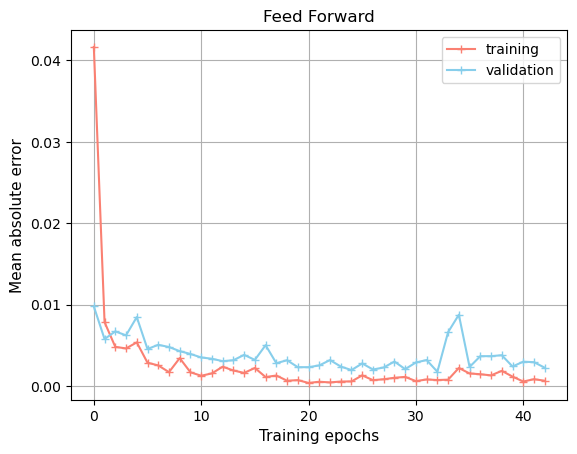

In [44]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'], "+-", label='training', color = "salmon")
plt.plot(h.history['val_loss'], "+-", label='validation', color = "skyblue")
plt.legend(fontsize=10) 
plt.title('Feed Forward')
plt.grid()
plt.xlabel('Training epochs', fontsize=11)
plt.ylabel('Mean absolute error', fontsize=11)
#plt.xlim(0, 200)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


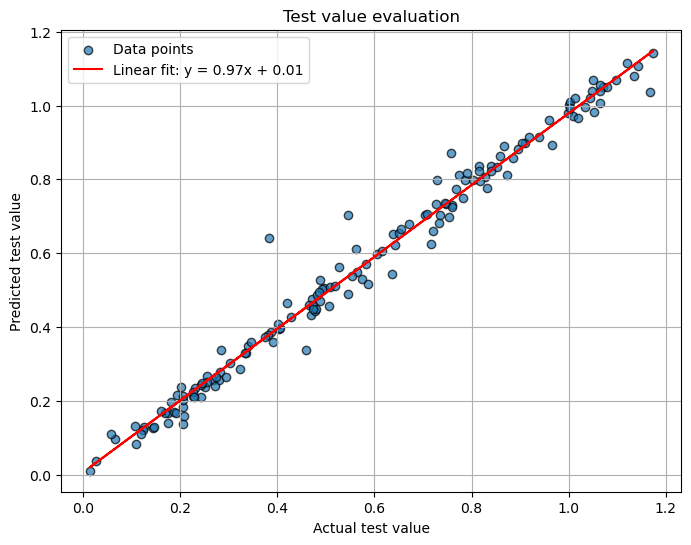

In [45]:
# visualize the prediction error
y_pred= best_model.predict(X_test)

# Perform linear regression
coefficients = np.polyfit(y_test.to_numpy().ravel(), y_pred.ravel(), 1)  # Fit a line (degree 1)
slope, intercept = coefficients

# Create the regression line
regression_line = slope * y_test + intercept

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred.ravel(), alpha=0.7, edgecolor='k', label='Data points')

# Plot the regression line
plt.plot(y_test, regression_line, color='red', label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}')

# Add labels, legend, and title
plt.xlabel('Actual test value')
plt.ylabel('Predicted test value')
plt.title('Test value evaluation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [46]:
print(h.history.keys())
r2_best = r2_score(y_test, y_pred)
print(r2_best)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
0.9823086895308274
